# Laboratory work #6: Reinforcement learning (variant 0)

Note: this notebook is expected to be opened with Jupyer Notebook. I don't know if it will work in Google Colab.

**Agenda**:
1. Problem formulation.
2. Experiments with value-iteration algorithm.
    * 2.1. Generated MDP.
    * 2.2. Plan of experiments.
    * 2.3. Results and analysis.
3. Conclusions.

In [17]:
# # Uncomment and run this cell to install needed libraries
# !pip3 install numpy
# !pip3 install pandas
# !pip3 install matplotlib
# !pip3 install altair
# !pip3 install pyvis

In [18]:
# Display plots in the notebook
%matplotlib inline

In [19]:
# Increase cell width of Jupyter notebook in the browserе
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [20]:
from typing import List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from pyvis.network import Network

# Disable limit on rows
alt.data_transformers.disable_max_rows();

## 1. Problem formulation.

We have a set of (400) 20x20 patches $ \mathbb{P} $. Among them, there are:
- black patches ($\mathbb{B}$)
- white patches ($\mathbb{W}$)
- red patches ($\mathbb{R}$)
- one blue patch $ b $ <br>
such that $\mathbb{B} \cup \mathbb{W} \cup \mathbb{R} \cup \{b\} = \mathbb{P}$ and they are mutually disjoint.

The functions $X : \mathbb{P} \to \{0,...,19\} $ and $Y : \mathbb{P} \to \{0,...,19\} $ are functions that map patches to coordinates.

Each patch has unique x, y coordinates: 
$$ \forall x \in \{0,...,19\}, \forall y \in \{0,...,19\}, \exists! p \in \mathbb{P} : X(p) = x \land Y(p) = y $$
We denote a patch with coordinates $x$ and $y$ by $Patch(x, y)$.

The coordinates of the blue patch is fixed: $ X(b) = 19, Y(b) = 19 $

Also we have a set of the black patches that contain a teleport on the right side of the patch $\mathbb{T_{right} \subset \mathbb{B}}$ and a set of the black patches that contain a teleport on the left side of the patch $\mathbb{T_{left} \subset \mathbb{B}}$. The sets are disjoint, of the same cardinality ($|\mathbb{T_{right}}| = |\mathbb{T_{left}}|$). There is a one-to-one correspondance $T: \mathbb{T_{right}} \to \mathbb{T_{left}}$. We say that the teleport $tel1$ from $\mathbb{T_{right}}$ and the teleport $tel2$ from $\mathbb{T_{left}}$ form a pair if and only if $T(tel1) = tel2$.

### We introduce our MDP (Markov Decision Process), which is a 4-tuple $(S, A, P_a, R_a)$

**We first describe the states**:

The states $S$ in our situation are pairs of a non-white patch and a heading (direction), more precisely:
$$S = \{(\rho, h) \mid \rho \in \mathbb{P} \setminus \mathbb{W}, h \in \{0, 90, 180, 270\} \}$$

**Second we describe the actions**:

There are $3$ actions available in each state:
$$ A = \{ ''move\ forward'',\, ''turn\ left'',\, ''turn\ right'' \} $$

**Third we describe the probabilities**:

The function $P_a(s, s') = Pr(s_{t+1}=s' \mid  s_t=s, a_t=a)$ is the probability that action $a$ leads to a transition from state $s$ to state $s'$.
In particular for each patch $\rho \in \mathbb{P} \setminus \mathbb{W}$ and direction $h \in \{0, 90, 180, 270\}$:
$$P_{''turn\ left''} ((\rho, h), (\rho, (h - 90) \mod 360)) = q$$
$$P_{''turn\ left''} ((\rho, h), (\rho, (h + 90) \mod 360)) = 1 - q$$
$$P_{''turn\ right''} ((\rho, h), (\rho, (h + 90) \mod 360)) = q$$
$$P_{''turn\ right''} ((\rho, h), (\rho, (h - 90) \mod 360)) = 1 - q$$

For all $\rho \in \mathbb{T_{right}}$:
$$P_{''move\ forward''} ((\rho, 90), (T(\rho), 90)) = p$$
$$P_{''move\ forward''} ((\rho, 90), (\rho, 90)) = 1 - p$$

For all $\rho \in \mathbb{T_{left}}$:
$$P_{''move\ forward''} ((\rho, 270), (T^{-1}(\rho), 270)) = p$$
$$P_{''move\ forward''} ((\rho, 270), (\rho, 270)) = 1 - p$$

Performing action "move forward" in the state of facing upward, the probability to remain in the same state, when the upper patch is white or doesn't exist, is $1$, otherwise the probability to move one patch up is $p$ and the probability to remain in the same state is $1-p$:
$$
\forall \rho \in \mathbb{P} \setminus \mathbb{W}:
$$
$$
((Y(\rho) + 1 > 19 \lor Patch(X(\rho), Y(\rho) + 1) \in \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 0), (\rho, 0)) = 1))
$$
$$
\land
$$
$$
((Y(\rho) + 1 \leq 19 \land Patch(X(\rho), Y(\rho) + 1) \notin \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 0), (Patch(X(\rho), Y(\rho) + 1), 0)) = p \land P_{''move\ forward''} ((\rho, 0), (\rho, 0)) = 1-p))
$$

Performing action "move forward" in the state of facing bottom, the probability to remain in the same state, when the bottom patch is white or doesn't exist, is $1$, otherwise the probability to move one patch down is $p$ and the probability to remain in the same state is $1-p$:
$$
\forall \rho \in \mathbb{P} \setminus \mathbb{W}:
$$
$$
((Y(\rho) - 1 < 0 \lor Patch(X(\rho), Y(\rho) - 1) \in \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 180), (\rho, 180)) = 1))
$$
$$
\land
$$
$$
((Y(\rho) - 1 \geq 0 \land Patch(X(\rho), Y(\rho) - 1) \notin \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 180), (Patch(X(\rho), Y(\rho) - 1), 180)) = p \land P_{''move\ forward''} ((\rho, 180), (\rho, 180)) = 1-p))
$$

Performing action "move forward" in the state facing right when patch does not contain teleports on the right of the patch, the probability to remain in the same state, when the right patch is white or doesn't exist, is $1$, otherwise the probability to move one patch right is $p$ and the probability to remain in the same state is $1-p$:
$$
\forall \rho \in \mathbb{P} \setminus \mathbb{W} \setminus \mathbb{T_{right}}:
$$
$$
((X(\rho) + 1 > 19 \lor Patch(X(\rho) + 1, Y(\rho)) \in \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 90), (\rho, 90)) = 1))
$$
$$
\land
$$
$$
((X(\rho) + 1 \leq 19 \land Patch(X(\rho) + 1, Y(\rho)) \notin \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 90), (Patch(X(\rho) + 1, Y(\rho)), 90)) = p \land P_{''move\ forward''} ((\rho, 90), (\rho, 90)) = 1-p))
$$

Performing action "move forward" in the state facing left when the patch does not contain teleports on the left of the patch, the probability to remain in the same state, when the left patch is white or doesn't exist, is $1$, otherwise the probability to move one patch left is $p$ and the probability to remain in the same state is $1-p$:
$$
\forall \rho \in \mathbb{P} \setminus \mathbb{W} \setminus \mathbb{T_{left}}:
$$
$$
((X(\rho) - 1 < 0 \lor Patch(X(\rho) - 1, Y(\rho)) \in \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 270), (\rho, 270)) = 1))
$$
$$
\land
$$
$$
((X(\rho) - 1 \geq 0 \land Patch(X(\rho) - 1, Y(\rho)) \notin \mathbb{W}) \implies (P_{''move\ forward''} ((\rho, 270), (Patch(X(\rho) - 1, Y(\rho)), 270)) = p \land P_{''move\ forward''} ((\rho, 270), (\rho, 270)) = 1-p))
$$

**Finally we describe the rewards**:

$R_a(s, s')$ is the expected reward received when transitioning from state $s$ to $s'$ under action $a$. For any action $a \in \{''move\ right'', ''move\ left''\}$ and any state $s \in (\mathbb{P} \setminus \mathbb{W}) \times \{0, 90, 180, 270\}$:
$$R_a(s, (s + 90) \mod 360) = R_a(s, (s - 90) \mod 360) = -1$$

The reward for transition from state $(\rho, h)$ to state $(\rho', h)$ under action $''move\ forward''$ is:
$$R_{''move\ forward''}((\rho, h), (\rho', h)) = 
\begin{cases}
    -1,& \text{if } \rho = \rho' \\
    teleport\_reward,& \text{if } \rho \neq \rho' \land (h = 90 \land \rho' \in \mathbb{T_{right}})  \\
    teleport\_reward,& \text{if } \rho \neq \rho' \land (h = 270 \land \rho' \in \mathbb{T_{left}})  \\
    black\_reward,& \text{if } \rho \neq \rho' \land \rho' \in \mathbb{B} \land \neg (h = 90 \land \rho' \in \mathbb{T_{right}}) \land \neg (h = 270 \land \rho' \in \mathbb{T_{left}}) \\
    red\_reward,& \text{if } \rho \neq \rho' \land \rho' \in \mathbb{R} \land \neg (h = 90 \land \rho' \in \mathbb{T_{right}}) \land \neg (h = 270 \land \rho' \in \mathbb{T_{left}}) \\
    blue\_reward,& \text{if } \rho \neq \rho' \land \rho' = b \land \neg (h = 90 \land \rho' \in \mathbb{T_{right}}) \land \neg (h = 270 \land \rho' \in \mathbb{T_{left}}) \\
\end{cases}
$$

### Example
So far, we have not specified the MDP completely, as we haven't assigned values to the following variables:
- $p$
- $q$
- $teleport\_reward$
- $black\_reward$
- $red\_reward$
- $blue\_reward$
- $\mathbb{B}$ - set of black patches
- $\mathbb{R}$ - set of red patches
- $\mathbb{W}$ - set of white patches

We set:
- $teleport\_reward = -1$
- $black\_reward = -2$
- $red\_reward = -10$
- $blue\_reward = 10$

We will assign patches to $\mathbb{W}$, $\mathbb{R}$ randomly. $\mathbb{B}$ can be found unambiguously given $\mathbb{W}$ and $\mathbb{R}$.

We will assign $0.8$ and $0.7$ to $p$ and $q$ respectively.

On the following interactive figure you can see a part of the graph representing an example of the described MDP:

In [21]:
def parse_netlogo_list_of_lists(netlogo_lst_of_lsts: str):
    netlogo_lst_of_lsts = netlogo_lst_of_lsts[1:-1]
    while netlogo_lst_of_lsts.find('[') != -1:
        start = netlogo_lst_of_lsts.find('[')
        end = netlogo_lst_of_lsts.find(']')
        yield netlogo_lst_of_lsts[start+1:end]
        netlogo_lst_of_lsts = netlogo_lst_of_lsts[end+1:]

def parse_patches_repr(patches_repr: str):
    patches_dict = {}
    for p_repr in parse_netlogo_list_of_lists(patches_repr):
        x, y, color = p_repr.split()
        x, y = [int(i) for i in [x, y]]
        patches_dict[(x, y)] = color
    return patches_dict

def parse_teleports_repr(teleports_repr: str):
    teleports = []
    for t_repr in parse_netlogo_list_of_lists(teleports_repr):
        x1, y1, x2, y2  = (int(i) for i in t_repr.split())
        teleports.append(((x1, y1), (x2, y2)))
    return teleports

def parse_params_repr(params_repr: str):
    params = {}
    for p_repr in parse_netlogo_list_of_lists(params_repr):
        pname, pval = p_repr.split()
        pval = float(pval)
        params[pname] = pval
    return params

def read_game_repr(fname: str):
    game_repr = pd.read_csv(fname, skiprows=6)
    game_repr = game_repr[['get-patches-representation', 'get-teleports-representation', 'get-params-representation', 'u']]
    game_repr.columns = ['patches', 'teleports', 'params', 'u']
    
    patches_dict = parse_patches_repr(game_repr.loc[0, 'patches'])
    teleports = parse_teleports_repr(game_repr.loc[0, 'teleports'])
    params_dict = parse_params_repr(game_repr.loc[0, 'params'])
    
    return patches_dict, teleports, params_dict

In [22]:
patches_dict, teleports, params_dict = read_game_repr("game_repr.csv")

In [23]:
def patch_name(pos: tuple, heading: int):
    return f"patch {pos}, heading {heading}"

def action_name(pos, heading, action):
    return f"{pos} {heading} {action}"

def rotate_vector(vec: tuple, angle_in_degrees: int):
    alpha = angle_in_degrees / 180 * np.pi
    matrix = ((np.cos(alpha), np.cos(alpha + np.pi / 2)),
            (np.sin(alpha), np.sin(alpha + np.pi / 2)))
    return (matrix[0][0] * vec[0] + matrix[0][1] * vec[1],
           matrix[1][0] * vec[0] + matrix[1][1] * vec[1])

def add_actions(base_pos: tuple, heading: int, g, state_pos):
    poses = {
        'move left': (-150, -160),
        'move right': (120, -150),
        'move forward': (-40, -190)
    }

    for pos in poses:
        poses[pos] = rotate_vector(poses[pos], heading)
        poses[pos] = (base_pos[0] + poses[pos][0], base_pos[1] + poses[pos][1])

    for key in poses:
        pos = poses[key]
        cur_action_name = action_name(state_pos, heading, key)
        g.add_node(cur_action_name, x=pos[0], y=pos[1], fixed = {'x': True, 'y': True}, size=15, label=' ', title=key)
        g.add_edge(patch_name(state_pos, heading), cur_action_name, physics=False)

def contains_teleport(pos: tuple, on_right: bool):
    idx = 0 if on_right else 1
    for tels in teleports:
        if tels[idx] == pos:
            return tels if on_right else tels[::-1]
    return False

def add_edge_helper(g, name1, name2, probability, reward):
    try:
        g.add_edge(name1, name2, physics=False, title=f"probability: {probability}, reward: {reward}")
    except AssertionError:
        pass

def out_of_bounds(pos: tuple):
    return not ((0 <= pos[0] < 20) and (0 <= pos[1] < 20))

def add_action_state_edges(pos: tuple, heading: int, g):
    actions = ['move left', 'move right', 'move forward']
    add_edge_helper(g, action_name(pos, heading, 'move left'), patch_name(pos, (heading - 90) % 360), 'q', -1)
    add_edge_helper(g, action_name(pos, heading, 'move left'), patch_name(pos, (heading + 90) % 360), '1-q', -1)

    add_edge_helper(g, action_name(pos, heading, 'move right'), patch_name(pos, (heading + 90) % 360), 'q', -1)
    add_edge_helper(g, action_name(pos, heading, 'move right'), patch_name(pos, (heading - 90) % 360), '1-q', -1)

    fd_action = action_name(pos, heading, 'move forward')


    if heading in [90, 270]:
        tels = contains_teleport(pos, heading == 90)
        if tels != False:
            my_tel, other_tel = tels
            add_edge_helper(g, fd_action, patch_name(other_tel, heading), 'p', 'teleport-reward')
            add_edge_helper(g, fd_action, patch_name(pos, heading), '1-p', -1)
            assert my_tel == pos, "They must be equal"
            return
    
    next_patch_pos = list(pos)
    if heading == 0:
        next_patch_pos[1] += 1
    elif heading == 90:
        next_patch_pos[0] += 1
    elif heading == 180:
        next_patch_pos[1] -= 1
    elif heading == 270:
        next_patch_pos[0] -= 1
    else:
        print(heading)
        return
        assert False, "This should not be called"
    next_patch_pos = tuple(next_patch_pos)
    
    if out_of_bounds(next_patch_pos) or patches_dict[next_patch_pos] == 'white':
        add_edge_helper(g, fd_action, patch_name(pos, heading), 1, -1)
    else:
        next_patch_color = patches_dict[next_patch_pos]
        if next_patch_color == 'black':
            cost = 'black-reward'
        elif next_patch_color == 'red':
            cost = 'red-reward'
        elif next_patch_color == 'blue':
            cost = 'blue-reward'
        else:
            assert False, "This should not be called"
        add_edge_helper(g, fd_action, patch_name(next_patch_pos, heading), 'p', cost)
        add_edge_helper(g, fd_action, patch_name(pos, heading), '1-p', -1)


def create_graph(patches: dict):
    g = Network(notebook=True, cdn_resources='remote', directed=True)
    for pos, color in patches.items():
        if color != 'white':
            base_pos = (pos[0]*500, -pos[1]*500)
            base_dist = 90
            g.add_node(patch_name(pos, 0),
                       x=base_pos[0],
                       y=base_pos[1] - base_dist,
                       label=None,
                       title=patch_name(pos, 0),
                       fixed = {'x': True, 'y': True},
                       color=color)
            add_actions(base_pos, 0, g, pos)

            g.add_node(patch_name(pos, 90),
                       x=base_pos[0] + base_dist,
                       y=base_pos[1],
                       label=None,
                       title=patch_name(pos, 90),
                       fixed = {'x': True, 'y': True},
                       color=color)
            add_actions(base_pos, 90, g, pos)

            g.add_node(patch_name(pos, 180),
                       x=base_pos[0],
                       y=base_pos[1] + base_dist,
                       label=None,
                       title=patch_name(pos, 180),
                       fixed = {'x': True, 'y': True},
                       color=color)
            add_actions(base_pos, 180, g, pos)

            g.add_node(patch_name(pos, 270),
                       x=base_pos[0] - base_dist,
                       y=base_pos[1],
                       label=None,
                       title=patch_name(pos, 270),
                       fixed = {'x': True, 'y': True},
                       color=color)
            add_actions(base_pos, 270, g, pos)
    for pos, color in patches.items():
        if color != 'white':
            for heading in [0, 90, 180, 270]:
                add_action_state_edges(pos, heading, g)
    return g

In [24]:
# # This displays full graph
# create_graph(patches_dict).show('./static/full_example_graph.html')

In [25]:
g = create_graph({key: patches_dict[key] for key in [(i, j) for i in range(0, 5) for j in range(13, 19)] + [(11, 18)]})

In [26]:
g.show("./static/part_of_example_graph.html")

Patches for $\mathbb{W}$ and $\mathbb{R}$ were sampled randomly: 20 for $\mathbb{W}$ and 20 for $\mathbb{R}$. The above displayed graph is only a part of the full graph. To see the full graph, please open `static/full_example_graph.html` in a browser. **Note** that it is laggy and might take some time to open (for me it was around 3 seconds).

## 2. Experiments with value-iteration algorithm.

### 2.1. Generated MDP.

For experiments with value iteration algorithm, we generated the following MDP in NetLogo:

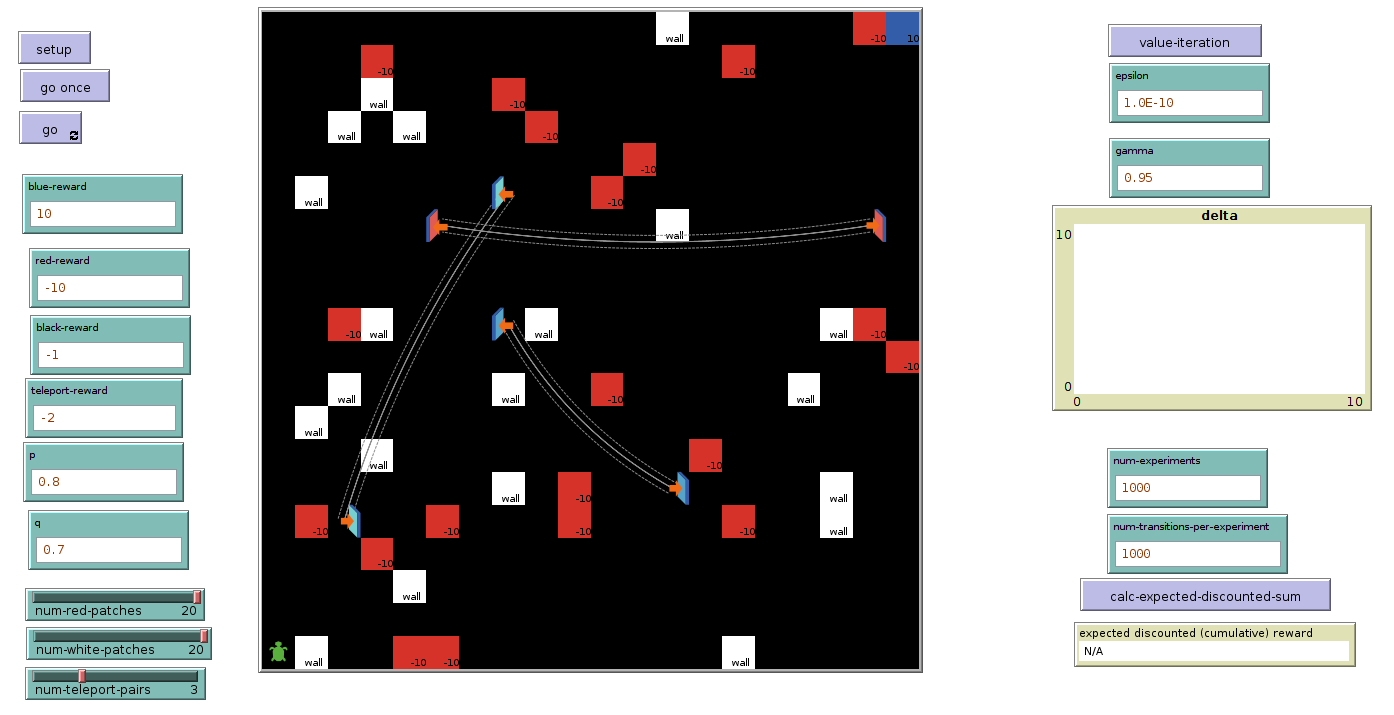

### 2.2. Plan of experiments.

We then proceed according to the following plan:

- For each gamma :
    * For each epsilon :
        - Run value iteration algorithm until convergence 
            - Record the final value of the state (patch (0, 0), heading 0) produced by value iteration algorithm
        - Simulate 1000 Markov Process observations under the policy produced by value iteration, run each observation for 1000 steps (transitions).
            - Record the average discounted sum, i.e. $ \frac{ \sum_{i=1}^{1000}{ \sum_{j=1}^{1000}{\gamma^{i-1} r_j^{(i)}}} }{ 1000 } $, where $r_j^{(i)}$ is the reward from $i$th transition in $j$th experiment.

### 2.3. Results and analysis.

In [27]:
vi_data = pd.read_csv('value_iter_exper.csv', skiprows=6)

In [28]:
vi_data = vi_data.iloc[:, [3, 8, -2, -1]]

In [29]:
vi_data.columns = ['gamma', 'epsilon', 'value_from_value_iteration', 'avg_discounted_reward']

In [30]:
vi_data = vi_data.melt(id_vars=['gamma', 'epsilon'], value_vars=['value_from_value_iteration', 'avg_discounted_reward'])

Upon running the experiments, we gathered the values for state "patch (0, 0), heading 0" calculated by value-iteration-agorithm and average discounted reward calculated by Markov process simulation. We found those for each combination of gamma and epsilon. The following interactive figure displays the dependence of theese two quantities on gamma and epsilon:

In [31]:
ch = alt.Chart(vi_data, width=400, height=400).mark_point(opacity=0.75, filled=True).encode(
    x=alt.X('epsilon:O', scale=alt.Scale(type="log")),
    y=alt.Y('value:Q', scale=alt.Scale(zero=False)),
    color='variable',
    shape='variable',
    size=alt.Size('variable', scale=alt.Scale(range=[50, 150])),
    tooltip = alt.Tooltip(['variable', 'value'])
).facet(
    facet='gamma',
    columns=2
).resolve_scale(
    x='independent',
    y='independent'
)
ch.interactive(bind_x=True)

alt.FacetChart(...)

We make the following inferences from the above data:
1. Average discounted sum for the policy does not change much with epsilon.
2. The value calculated by value-iteration algorithm and the average discounted sum obtained by running the simulation of Markov Decision Process with policy calculated by value-iteration converge as epsilon tends to 0.

## 3. Conclusions.

1. I described the MDP I deal with in this report. 
2. I ran the value-iteration algorithm for different combinations of gamma and epsilon.
3. I ran the simulations with policy optained from value-iteration for different combinations of gamma and epsilon.
4. I made inferences from the gathered data.